# Autocorrelation for Glauber dynamics on homogeneous graph

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Plots, Printf, Statistics, ProgressMeter
ProgressMeter.ijulia_behavior(:clear);

In [123]:
T = 8
N = 10^3
k = 3
gg = random_regular_graph(N, k)
# gg = SimpleGraph(prim_mst(gg)); @assert is_connected(gg)
g = IndexedGraph(gg)
p⁰ = fill([0.75, 0.25], N)

gl = Glauber(Ising(g), T; p⁰);

In [124]:
# using GraphRecipes
# graphplot(gg, size=(200,200), nodeshape=:circle, curves=false)

In [125]:
bp = mpbp(gl)
cb = CB_BP(bp);

In [ ]:
svd_trunc = TruncBond(6)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-4)
@show iters
b_bp = beliefs(bp)
m_bp = belief_expectations(bp);

In [ ]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", size=(300,200), label="",
    yaxis=:log10)

In [ ]:
sms = SoftMarginSampler(bp);

In [ ]:
ns = 3*10^5
sms = sample!(sms, ns);

In [ ]:
b_mc = marginals(sms)
m_mc = [[bbb[1]-bbb[2] for bbb in bb] for bb in b_mc];

In [ ]:
title = @sprintf "Monte Carlo %.0e samples" length(sms.X)
pl_mc = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title=title)
for i in 1:N
    plot!(pl_mc, 0:T, m_mc[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
pl_bp = plot(xlabel="time", ylabel="magnetization", xticks=0:5:T, title="MPBP")
for i in 1:N
    plot!(pl_bp, 0:T, m_bp[i], label="i=$i", m=:o, ms=3, lw=1, markerstrokecolor=:auto)
end
r = round( cor(reduce(vcat, m_bp), getproperty.(reduce(vcat, m_mc), :val)), digits=4)
pl_sc = scatter(reduce(vcat, m_bp), reduce(vcat, m_mc), xlabel="MPBP", ylabel="MonteCarlo", 
    label="magnetization", ms=3, c=:black, legend=:outertopright, title="ρ = $r",
    xlims=(-1,1), ylims=(-1,1), widen=true)
plot!(identity, label="", size=(300,300))
println("Max matrix size: ", svd_trunc.mprime, "x", svd_trunc.mprime)
plot(pl_mc, pl_bp, pl_sc, titlefontsize=10, size=(950, 300), legend=:outerbottomright, 
    margin=5Plots.mm, layout=(1,3))

In [ ]:
c_mc = autocovariances(sms);

In [ ]:
c_bp = autocovariances(bp);

In [167]:
ci = c_bp[1]

9×9 Matrix{Float64}:
 0.0  -0.00171558   0.260029   -0.00168874  …  -0.00166694   0.024262
 0.0   0.0         -0.0022539   0.219625        0.0487365   -0.00154003
 0.0   0.0          0.0        -0.00190903     -0.0022919    0.0374212
 0.0   0.0          0.0         0.0             0.06159     -0.00146865
 0.0   0.0          0.0         0.0            -0.0025508    0.0432823
 0.0   0.0          0.0         0.0         …   0.071769    -0.00160505
 0.0   0.0          0.0         0.0            -0.00246403   0.0497799
 0.0   0.0          0.0         0.0             0.0         -0.0012881
 0.0   0.0          0.0         0.0             0.0          0.0

In [183]:
using ColorSchemes
function plot_autocovs(c, i, T; skip_even=false, title, kw...)
    step = skip_even ? 2 : 1
    ci = c[i]
    us = 2:2:T
    cg = cgrad(:matter, length(us), categorical=true)
    pl = plot(xlabel="\$\\Delta t \$",  
        ylabel="\$\\langle\\sigma_i^t\\sigma_i^{t+\\Delta t}\\rangle-\\langle\\sigma_i^t\\rangle\\langle\\sigma_i^{t+\\Delta t}\\rangle \$", 
            legend=:outertopright, title=title)
     
    for (j,u) in enumerate(us)
        if eltype(ci) <: MatrixProductBP.Measurement
            y = getproperty.(ci[(0:step:u-1) .+ 1,u+1], :val)
            yerr = getproperty.(ci[(0:step:u-1) .+ 1,u+1], :err)
            plot!(pl, u:-step:1, y, label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j], ribbon=yerr; kw...) 
        else
            plot!(pl, u:-step:1, ci[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
        end
    end
    pl
end    

plot_autocovs (generic function with 1 method)

In [184]:
i = 2
skip_even = true
pl_autocov_mc = plot_autocovs(c_mc, i, T; title = "Monte Carlo - i=$i", skip_even)
pl_autocov_bp = plot_autocovs(c_bp, i, T; title = "MPBP - i=$i", skip_even, legend=false);

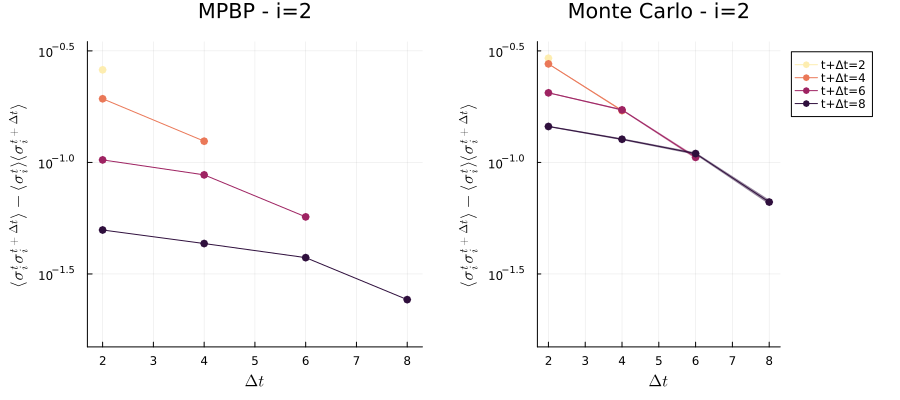

In [186]:
yl = ( min(ylims(pl_autocov_mc)[1], ylims(pl_autocov_bp)[1]), 
        max(ylims(pl_autocov_mc)[2], ylims(pl_autocov_bp)[2]) )
plot(pl_autocov_bp, pl_autocov_mc, size=(900,400), margin=5Plots.mm, ylims=yl, widen=1.1, yaxis=:log10)

In [154]:
T

8